In [1]:
import os
import numpy as np
import pandas as pd
from nilearn import image
from nilearn import plotting

C:\Users\davide\anaconda3\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
C:\Users\davide\anaconda3\lib\site-packages\nilearn\datasets\__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
main_folder = "C:\\Users\\davide\\Documents\\GitHub\\fmri_scripts\\dti" 

# Files
tfce_map = image.load_img(os.path.join(main_folder, 'tbss_tfce_corrp_tstat1.nii'))
mean_FA_skeletonised_map = image.load_img(os.path.join(main_folder, 'mean_FA_skeleton.nii'))
all_FA_skeletonised_map = image.load_img(os.path.join(main_folder, 'all_FA_skeletonised.nii'))

# Atlas and Anatomical Background Image
atlas_map = image.load_img(os.path.join(main_folder, 'JHU-ICBM-labels-1mm.nii') )
bck_img_map = image.load_img(os.path.join(main_folder, 'MNI152_T1_1mm_Brain.nii'))
atlas_labels = pd.read_csv(os.path.join(main_folder, 'atlas.csv'))

In [3]:
#Data in numpy.array format
tfce_map_data = tfce_map.get_fdata() 
all_FA_skeletonised_map_data = all_FA_skeletonised_map.get_fdata()
mean_FA_map_data = mean_FA_skeletonised_map.get_fdata()
atlas_data = atlas_map.get_fdata()

In [4]:
# TFCE MAP binarised with threshold 0.95
tfce_map_binarised = image.math_img("np.where((img > 0.95),1,0)", img=tfce_map)
print('Number of significant voxels: ' + str((tfce_map_binarised.get_fdata()>0).sum()))

Number of significant voxels: 82020


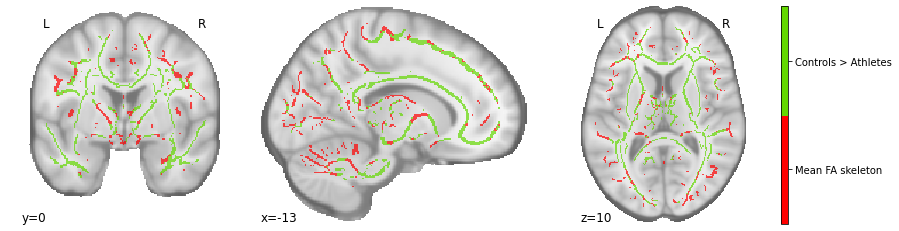

In [5]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import colorbar, colors

#Map containing both the Mean FA and TFCE maps
tfce_mean_FA_merged = image.math_img("img + np.where(img2>0.2,1,0)", img=tfce_map_binarised, img2 = mean_FA_skeletonised_map)

#Plotting results
fig, (img_ax, cbar_ax) = plt.subplots(
    1,
    2,
    gridspec_kw={"width_ratios": [10.0, 0.1], "wspace": 0.0},
    figsize=(14, 4),
)

cmap = ListedColormap(["red", "#63d800"])  #You can change these two colours (https://www.w3schools.com/colors/colors_rgb.asp)
plotting.plot_roi(tfce_mean_FA_merged,
                  bg_img = bck_img_map,
                  cut_coords=(-13, 0, 10), #Slices (X, Y, Z)
                  black_bg = False,
                  cmap=cmap,
                  axes=img_ax,
                  draw_cross = False,
                  annotate = True) # If you want to remove annotations

norm = colors.Normalize(vmin=0, vmax=2) # Cmap will have 2 levels
cbar = colorbar.ColorbarBase(
    cbar_ax,
    ticks=[0.5, 1.5],
    norm=norm,
    orientation="vertical",
    cmap=cmap,
    spacing="proportional",
)
cbar_ax.set_yticklabels(["Mean FA skeleton", "Controls > Athletes"])

plt.savefig('tfce_MeanFA_merged_fancy.jpg', dpi = 300, bbox_inches='tight') #This saves it at 300dpi for your thesis

In [6]:
# Analysis of the different groups of tracts

from nilearn.image import new_img_like
from nilearn.reporting import get_clusters_table

tracts = [[3,4,5], [17,18,19,20,21,22], [41,42]]  # ids in atlas_labels

th = 0.95 #threshold (0.95)
csize = 1 #Custer size (for the tables, please check these results with the FSL function "cluster") 
all_tables = [] #Array containing all the output tables

group = 1
for group_tracts in tracts:
    
    print('Group: ' + str(group)) # Group n.
    group_name = " ".join((atlas_labels['abbr'].loc[atlas_labels['id'].isin(group_tracts)].tolist()))
    print('Tracts: ' + group_name)
    
    atlas_masked = np.where(np.in1d(atlas_data, group_tracts).reshape(atlas_data.shape)==True,1,0)
    atlas_masked = new_img_like(atlas_map, atlas_masked, affine=None, copy_header=True) #Mask containing the tracts
    image.math_img("img", img=atlas_masked).to_filename('group_' + str(group) + '_.nii') #Saving the mask into a new nifti file
    #nb. I used these nifti files with MRIcroGL to create images of the tracts (check files eg. 3_groups_lateral_view.png)
    
    print('Voxels in the mask: ' + str(int(atlas_masked.get_fdata().sum())))
    print('Mask saved in nifti file ' + 'group_' + str(group) + '_.nii')
    print('\n')

    tfce_map_masked = image.math_img("img * img2", img=tfce_map, img2 = atlas_masked) #Applying  mask to TFCE map
    
    # For each group of tracts, I save the new TFCE map containing only the values in the tracts.
    # You can use these maps with the FSL function CLUSTER to check the results (I'd actually use FSL results instead
    # of the ones in the table "all_tables").
    
    image.math_img("img", img=tfce_map_masked).to_filename('tfce_group_' + str(group) + '_.nii')
    
    this_table = get_clusters_table(tfce_map_masked, stat_threshold=th, #Clusters
                                    cluster_threshold=csize)  
    this_table['Tracts'] = 'Group_'+ str(group)   
    #this_table.drop('Peak Stat',axis=1, inplace=True) #I don't think it makes sense to report all the 0.998 values, maybe 
    # just say clusters with p <0.05 FWE
    
    all_tables.append(this_table)
    
    group += 1

Group: 1
Tracts: gCC bCC sCC
Voxels in the mask: 35291
Mask saved in nifti file group_1_.nii




C:\Users\davide\anaconda3\lib\site-packages\nilearn\reporting\_get_clusters_table.py:97: UserWarning: Attention: At least one of the (sub)peaks falls outside of the cluster body.
  warnings.warn(


Group: 2
Tracts: ALIC.R ALIC.L PLIC.R PLIC.L RIC.R RIC.L
Voxels in the mask: 18646
Mask saved in nifti file group_2_.nii


Group: 3
Tracts: SLF.R SLF.L
Voxels in the mask: 13212
Mask saved in nifti file group_3_.nii




In [13]:
groups = ['group_1','group_2','group_3']
g = 0
for table in all_tables:
    print(table)
    table.to_csv(groups[g] +'.csv')
    print('\n')
    g += 1

    Cluster ID     X     Y     Z  Peak Stat Cluster Size (mm3)   Tracts
0            1  28.0 -56.0  14.0      0.998               6960  Group_1
1           1a -20.0 -49.0  14.0      0.998                     Group_1
2           1b -10.0 -37.0  19.0      0.998                     Group_1
3           1c -20.0 -48.0  11.0      0.998                     Group_1
4            2 -12.0 -40.0  29.0      0.998                  1  Group_1
..         ...   ...   ...   ...        ...                ...      ...
106        104  -8.0 -32.0  15.0      0.976                  1  Group_1
107        105  -7.0 -31.0  15.0      0.976                  1  Group_1
108        106 -25.0 -58.0  14.0      0.972                  1  Group_1
109        107 -25.0 -59.0  13.0      0.972                  1  Group_1
110        108 -14.0 -36.0   9.0      0.972                  1  Group_1

[111 rows x 7 columns]


   Cluster ID     X     Y     Z  Peak Stat Cluster Size (mm3)   Tracts
0           1  23.0 -15.0  10.0      0.

In [8]:
all_tracts_means = []
all_tracts_sd = []

for group_tracts in tracts:
    #For each tract / group of tracts create a mask
    print('Extracting means and SD of tracts: ')
    print(" ".join((atlas_labels['abbr'].loc[atlas_labels['id'].isin(group_tracts)].tolist())))
    atlas_masked = np.where(np.in1d(atlas_data, group_tracts).reshape(atlas_data.shape)==True,1,0)
    atlas_masked = new_img_like(atlas_map, atlas_masked, affine=None, copy_header=True) #Mask containing the tracts
    means = [] #means for each participant for each tract / group of tracts
    sds = [] #sd for each participant for each tract / group of tracts
    for participant in range(0,all_FA_skeletonised_map.shape[3]):
        #print('Analysing participant: ' + str(participant+1))
        this_participant_sk_map = all_FA_skeletonised_map.get_fdata()[:,:,:,participant] #Map of the participant
        this_participant_sk_map = new_img_like(atlas_map, this_participant_sk_map, affine=None, copy_header=True)
        this_participant_sk_map_masked =  image.math_img("img * img2", img=this_participant_sk_map, img2 = atlas_masked) #Applying  mask
        mean = np.mean(this_participant_sk_map_masked.get_fdata()[atlas_masked.get_fdata()!=0])
        sd = np.std(this_participant_sk_map_masked.get_fdata()[atlas_masked.get_fdata()!=0])

        # The last command means: take the FA data from participant N, consider only the values that are 1 in the mask
        # and average them / or calculate sd (for that participant / tract) 
        
        #print('Mean FA: ' + str(round(mean,3)))
        #print('Std FA: ' + str(round(sd,3)))
        means.append(mean)
        sds.append(sd)

    all_tracts_means.append(means)
    all_tracts_sd.append(sds)

Extracting means and SD of tracts: 
gCC bCC sCC
Extracting means and SD of tracts: 
ALIC.R ALIC.L PLIC.R PLIC.L RIC.R RIC.L
Extracting means and SD of tracts: 
SLF.R SLF.L


In [9]:
# First group of tracts
print('First group of tracts')
print('Mean controls: ' + str(round(np.mean(all_tracts_means[0][0:14]),3)))
print('SD controls: ' + str(round(np.std(all_tracts_means[0][0:14]),3)))
print('Mean athletes: ' + str(round(np.mean(all_tracts_means[0][14:28]),3)))
print('SD athletes: ' + str(round(np.std(all_tracts_means[0][14:28]),3)))
print('\n')

#Second group of tracts
print('Second group of tracts')
print('Mean controls: ' + str(round(np.mean(all_tracts_means[1][0:14]),3)))
print('SD controls: ' + str(round(np.std(all_tracts_means[1][0:14]),3)))
print('Mean athletes: ' + str(round(np.mean(all_tracts_means[1][14:28]),3)))
print('SD athletes: ' + str(round(np.std(all_tracts_means[1][14:28]),3)))
print('\n')

#Third group of tracts
print('Third group of tracts')
print('Mean controls: ' + str(round(np.mean(all_tracts_means[2][0:14]),3)))
print('SD controls: ' + str(round(np.std(all_tracts_means[2][0:14]),3)))
print('Mean athletes: ' + str(round(np.mean(all_tracts_means[2][14:28]),3)))
print('SD athletes: ' + str(round(np.std(all_tracts_means[2][14:28]),3)))
print('\n')

First group of tracts
Mean controls: 0.177
SD controls: 0.004
Mean athletes: 0.165
SD athletes: 0.006


Second group of tracts
Mean controls: 0.179
SD controls: 0.004
Mean athletes: 0.167
SD athletes: 0.005


Third group of tracts
Mean controls: 0.139
SD controls: 0.005
Mean athletes: 0.128
SD athletes: 0.005




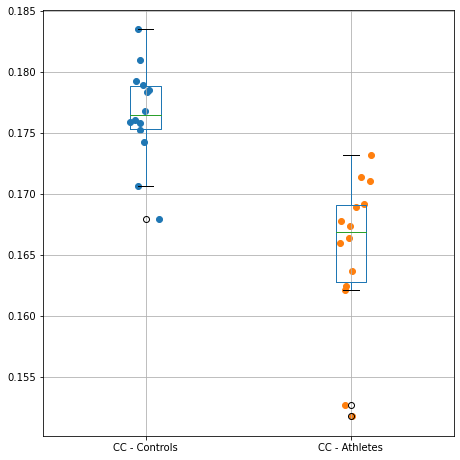

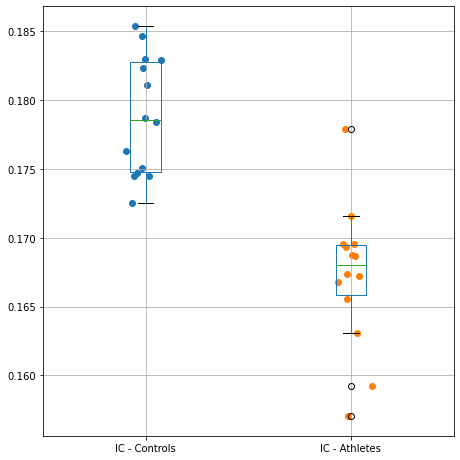

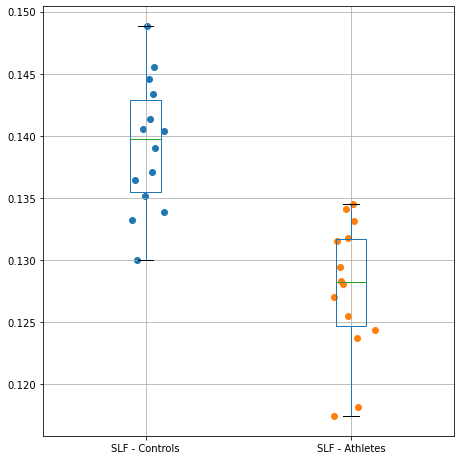

In [10]:
# Plots for the three groups of tracts
group_labels = ['CC','IC','SLF'] #Used for the plots

group = 0
for this_group in group_labels:
    
    plt.rcParams["figure.figsize"] = [6.50, 6.50]
    plt.rcParams["figure.autolayout"] = True
    data = pd.DataFrame({group_labels[group] + " - Controls": all_tracts_means[group][0:14],  group_labels[group] + " - Athletes": all_tracts_means[group][14:28]})
    data.boxplot()

    for i, d in enumerate(data):
       y = data[d]
       x = np.random.normal(i + 1, 0.04, len(y))
       plt.scatter(x, y)
    plt.show()
    
    group+=1

In [11]:
# Correlation analysis - examining the relationship between each tract and cognitive and clinical measures in the athletes
# The measures for each athlete: processing speed, working memory and symptom severity scores

p_speed = [520,500,480,515,440,500,520,500,460,520,560,450,480,420]
w_m = [4,4,4,4,2,4,4,3,3,4,4,4,4,3]
symp_sev = [3,17,8,6,27,11,5,17,0,41,43,41,12,20]

Group of tracts: CC
Correlation with Processing speed
p value: 0.999943, r=-2.1e-05


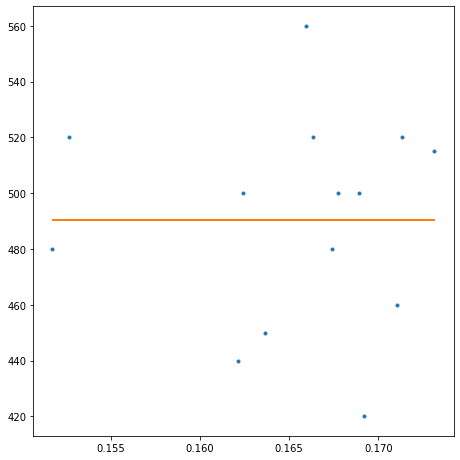

Correlation with Working Memory
p value: 0.968178, r=-0.011758


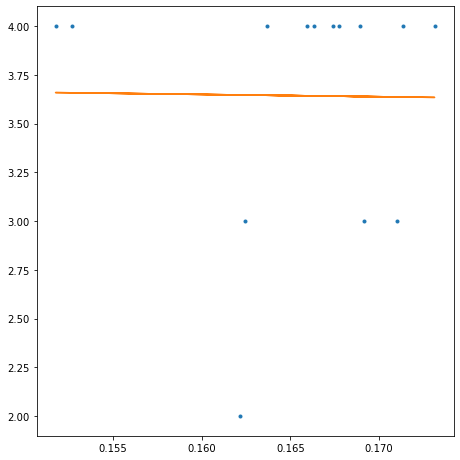

Correlation with Symptoms severity
p value: 0.768319, r=-0.08666


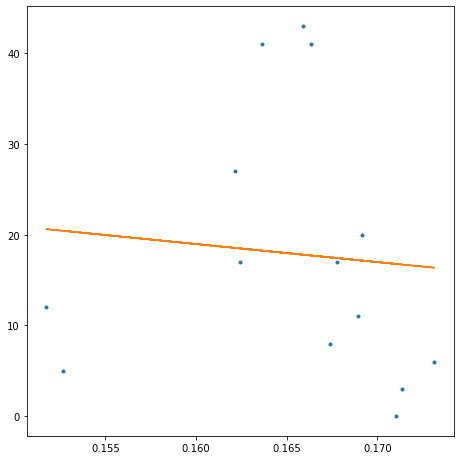

Group of tracts: IC
Correlation with Processing speed
p value: 0.746224, r=-0.095168


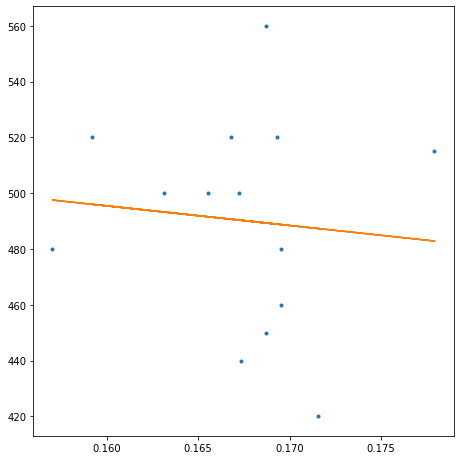

Correlation with Working Memory
p value: 0.68088, r=-0.120771


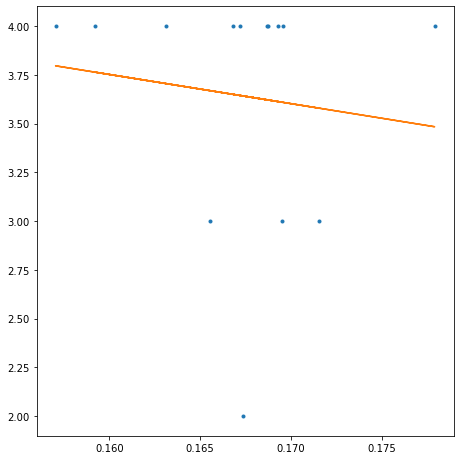

Correlation with Symptoms severity
p value: 0.882157, r=0.043671


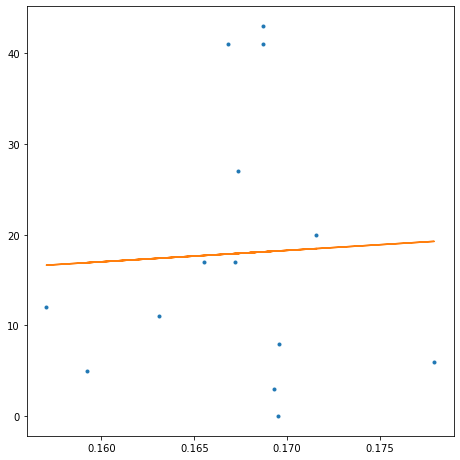

Group of tracts: SLF
Correlation with Processing speed
p value: 0.748804, r=-0.094171


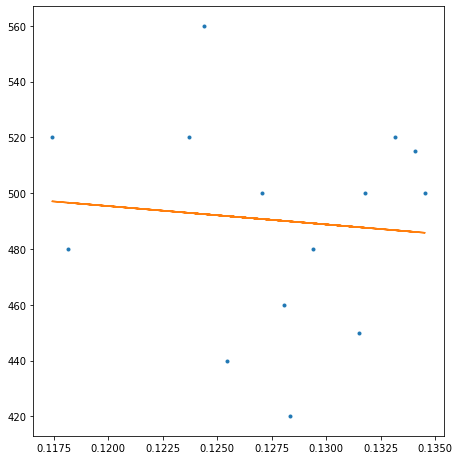

Correlation with Working Memory
p value: 0.769481, r=0.086214


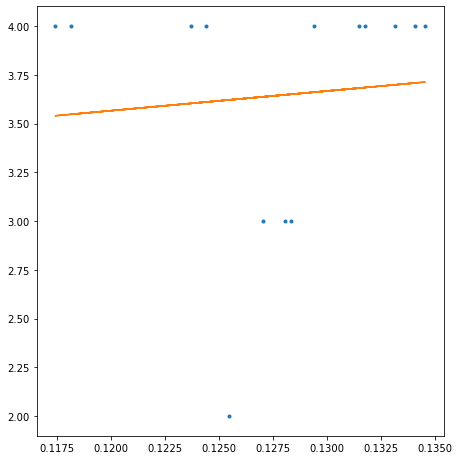

Correlation with Symptoms severity
p value: 0.66513, r=-0.127057


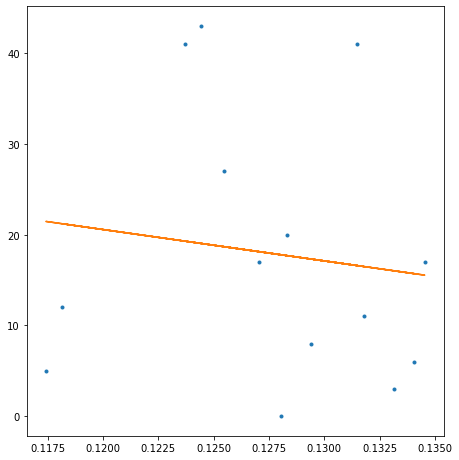

In [12]:
# Computing the correlation between FA values of each group and the three cog/cli measures

import scipy.stats
group_labels = ['CC','IC','SLF'] #Used for the plots
measure_labels = ['Processing speed', 'Working Memory', 'Symptoms severity']
group = 0

for this_group in group_labels:
 
    x = all_tracts_means[group][14:28]
    x = np.transpose(x)
    
    # Correlation with processing speed
    y = p_speed
    r,p  = scipy.stats.pearsonr(x, y)    # Pearson's r
    print('Group of tracts: ' + this_group)
    print('Correlation with Processing speed')
    print('p value: ' + str(round(p,6)) + ', r=' + str(round(r,6)))
    # Plot
    from numpy.polynomial.polynomial import polyfit
    b, m = polyfit(x, y, 1)
    plt.plot(x, y, '.')
    plt.plot(x, b + m * x, '-')
    plt.show()

    # Correlation with working memory
    y = w_m
    r,p  = scipy.stats.pearsonr(x, y)    # Pearson's r
    print('Correlation with Working Memory')
    print('p value: ' + str(round(p,6)) + ', r=' + str(round(r,6)))
    # Plot
    b, m = polyfit(x, y, 1)
    plt.plot(x, y, '.')
    plt.plot(x, b + m * x, '-')
    plt.show()
    
    # Correlation with sympt severity
    y = symp_sev
    r,p = scipy.stats.pearsonr(x, y)    # Pearson's r
    print('Correlation with Symptoms severity')

    print('p value: ' + str(round(p,6)) + ', r=' + str(round(r,6)))
    # Plot
    b, m = polyfit(x, y, 1)
    plt.plot(x, y, '.')
    plt.plot(x, b + m * x, '-')
    plt.show()
    
    group+=1